#__Perovskitas__
## Recuerda generar tu propio dataset en  la API, con el script que se encuentra en el mismo repositorio, o en su defecto dejo mi dataset  el que genere en la API

In [1]:
# importamos la librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import joblib # Importado para guardar modelos
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Carga de los datos
DATA_PATH = "/content/dataset_perovskitas_20251125_162228.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material_ID               1644 non-null   object 
 1   Formula                   1644 non-null   object 
 2   Band_Gap_eV               1644 non-null   float64
 3   Densidad_g_cm3            1644 non-null   float64
 4   Energia_Formacion_eatoms  1644 non-null   float64
 5   Es_Estable                1644 non-null   bool   
 6   Es_Perovskita             1644 non-null   bool   
 7   Structure_JSON            1644 non-null   object 
dtypes: bool(2), float64(3), object(3)
memory usage: 80.4+ KB


In [4]:
df.head(10)

,Material_ID,Formula,Band_Gap_eV,Densidad_g_cm3,Energia_Formacion_eatoms,Es_Estable,Es_Perovskita,Structure_JSON
0,mp-23485,Ag2HgI4,1.2219,5.751902,-0.512363,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
1,mp-13956,Ag2PSe3,1.1866,5.793370,-0.169408,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
2,mp-5625,Ag2SO4,1.2289,5.427368,-1.256613,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
3,mp-16913,Ag2SeO3,1.7022,6.004620,-0.825087,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
4,mp-29163,Ag2TeS3,1.2999,5.146247,-0.078950,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
5,mp-561620,Ag3AsS3,1.6278,5.393890,-0.160047,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
6,mp-555269,Ag3SbS3,1.5142,5.802741,-0.206789,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
7,mp-28812,Ag5BiO4,1.5002,8.200771,-0.658539,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
8,mp-37153,AgAsF6,1.6806,3.433120,-2.201692,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."
9,mp-16060,AgAuF4,1.0268,7.222443,-1.254504,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class..."


# 🧪 Análisis de Materiales: Extracción de Características y Scoring de Perovskitas

Este bloque de código implementa un pipeline de **Ingeniería de Características** para evaluar la viabilidad de diferentes materiales (perovskitas) en aplicaciones de energía solar.

---

## 1. 🔍 Extracción de Características Químicas (Parser)
La función `extraer_caracteristicas_avanzadas_mejoradas` actúa como un procesador de lenguaje natural aplicado a la química. Transforma la columna `Formula` en un vector numérico de 11 dimensiones:

* **Descomposición Estructural:** Identifica elementos individuales diferenciando mayúsculas de minúsculas y extrae sus subíndices (estequiometría).
* **Métricas de Complejidad:** * **Diversidad Atómica:** Basada en la *Entropía de Shannon*, mide la heterogeneidad de la mezcla.
    * **Complejidad de la Fórmula:** Relación logarítmica entre el número de elementos y el total de átomos.
* **Clasificación por Grupos:** Categoriza los elementos según su posición en la tabla periódica (Metales Alcalinos, de Transición, Halógenos, etc.).



---

## 2. 🎯 Modelo de Puntuación (Solar Score)
La función `calcular_score_material_solar_mejorado` asigna un valor entre **0.0 y 1.0** a cada material, ponderando cuatro criterios críticos de la física de semiconductores:

### 📊 Distribución de Pesos:
| Criterio | Peso | Lógica de Evaluación |
| :--- | :--- | :--- |
| **Band Gap (eV)** | **45%** | Utiliza una función exponencial para penalizar desviaciones del **valor ideal de 1.4 eV** (Límite de Shockley-Queisser). |
| **Estabilidad** | **35%** | Basado en la *Energía de Formación*. Se otorga puntaje máximo a materiales con energía $\le -2.0$ eV/átomo. |
| **Densidad** | **15%** | Evalúa el empaquetamiento atómico, priorizando el rango óptimo de **4 a 6 g/cm³**. |
| **Composición** | **5%** | Bonus por presencia de elementos favorables para la eficiencia fotovoltaica (Alcalinos y Halógenos). |



> **Uso:** El resultado final se almacena en la columna `Score_Material_Solar`, la cual sirve como etiqueta (**Target**) para el entrenamiento de modelos de Machine Learning.

In [5]:


# Asegurarnos de que tenemos las características avanzadas
def extraer_caracteristicas_avanzadas_mejoradas(formula):
    """Extraer características químicas más sofisticadas"""
    try:
        elementos = {}
        current_element = ""; current_count = ""
        for char in formula:
            if char.isupper():
                if current_element:
                    count = int(current_count) if current_count else 1
                    elementos[current_element] = count
                current_element = char; current_count = ""
            elif char.islower(): current_element += char
            elif char.isdigit(): current_count += char
        if current_element:
            count = int(current_count) if current_count else 1
            elementos[current_element] = count

        num_elementos = len(elementos)
        total_atomos = sum(elementos.values())
        proporciones = [count/total_atomos for count in elementos.values()]
        diversidad_atomica = -sum(p * np.log(p) for p in proporciones if p > 0)

        # Tipos de elementos más detallados
        metales_alcalinos = sum(elementos.get(e, 0) for e in ['Li', 'Na', 'K', 'Rb', 'Cs'])
        metales_alcalinoterreos = sum(elementos.get(e, 0) for e in ['Be', 'Mg', 'Ca', 'Sr', 'Ba'])
        metales_transicion = sum(elementos.get(e, 0) for e in [
            'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
            'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg'
        ])
        metaloides = sum(elementos.get(e, 0) for e in ['B', 'Si', 'Ge', 'As', 'Sb', 'Te'])
        no_metales = sum(elementos.get(e, 0) for e in ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Se', 'Br', 'I'])
        halogenos = sum(elementos.get(e, 0) for e in ['F', 'Cl', 'Br', 'I'])

        ratio_metal_no_metal = (metales_alcalinos + metales_alcalinoterreos + metales_transicion) / max(no_metales, 1)
        complejidad_formula = num_elementos * np.log(total_atomos)

        return (num_elementos, total_atomos, diversidad_atomica, metales_alcalinos,
                metales_alcalinoterreos, metales_transicion, metaloides, no_metales,
                halogenos, ratio_metal_no_metal, complejidad_formula)

    except Exception:
        return (3, 10, 1.0, 0, 0, 1, 1, 2, 0, 1.0, 3.0)

# Aplicar extracción mejorada
caracteristicas_mejoradas = df['Formula'].apply(extraer_caracteristicas_avanzadas_mejoradas)
df[['Num_Elementos', 'Total_Atomos', 'Diversidad_Atomica',
    'Metales_Alcalinos', 'Metales_Alcalinoterreos', 'Metales_Transicion',
    'Metaloides', 'No_Metales', 'Halogenos',
    'Ratio_Metal_NoMetal', 'Complejidad_Formula']] = pd.DataFrame(
    caracteristicas_mejoradas.tolist(), index=df.index
)

# Calcular score de material solar (target)
def calcular_score_material_solar_mejorado(row):
    """Score compuesto mejorado para celdas solares"""

    # 1. Band Gap óptimo (máximo alrededor de 1.4 eV) - más suave
    band_gap_diff = abs(row['Band_Gap_eV'] - 1.4)
    band_gap_score = np.exp(-band_gap_diff / 0.3)  # Función exponencial suave

    # 2. Estabilidad mejorada
    energia = row['Energia_Formacion_eatoms']
    if energia <= -2.0:
        estabilidad_score = 1.0
    elif energia <= 0:
        estabilidad_score = 1.0 - (abs(energia) - 2.0) / 2.0
    else:
        estabilidad_score = 0.1

    # 3. Densidad óptima (4-6 g/cm³ ideal)
    densidad = row['Densidad_g_cm3']
    if 4 <= densidad <= 6:
        densidad_score = 1.0
    else:
        densidad_score = 1.0 / (1 + abs(densidad - 5))

    # 4. Bonus por composición favorable
    composicion_bonus = 0.0
    if row['Metales_Alcalinos'] > 0: composicion_bonus += 0.1
    if row['Halogenos'] > 0: composicion_bonus += 0.1
    if row['Metales_Transicion'] > 0: composicion_bonus += 0.05

    composicion_bonus = min(composicion_bonus, 0.2)

    score_final = (
        0.45 * band_gap_score +
        0.35 * estabilidad_score +
        0.15 * densidad_score +
        0.05 * composicion_bonus
    )

    return min(score_final, 1.0)

df['Score_Material_Solar'] = df.apply(calcular_score_material_solar_mejorado, axis=1)

In [6]:
df.head(10)

,Material_ID,Formula,Band_Gap_eV,Densidad_g_cm3,Energia_Formacion_eatoms,Es_Estable,Es_Perovskita,Structure_JSON,Num_Elementos,Total_Atomos,Diversidad_Atomica,Metales_Alcalinos,Metales_Alcalinoterreos,Metales_Transicion,Metaloides,No_Metales,Halogenos,Ratio_Metal_NoMetal,Complejidad_Formula,Score_Material_Solar
0,mp-23485,Ag2HgI4,1.2219,5.751902,-0.512363,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,0.955700,0,0,3,0,4,4,0.750000,5.837730,1.000000
1,mp-13956,Ag2PSe3,1.1866,5.793370,-0.169408,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,1.011404,0,0,2,0,4,0,0.500000,5.375278,1.000000
2,mp-5625,Ag2SO4,1.2289,5.427368,-1.256613,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,0.955700,0,0,2,0,5,0,0.400000,5.837730,0.886994
3,mp-16913,Ag2SeO3,1.7022,6.004620,-0.825087,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,1.011404,0,0,2,0,4,0,0.500000,5.375278,0.797273
4,mp-29163,Ag2TeS3,1.2999,5.146247,-0.078950,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,1.011404,0,0,2,1,3,0,0.666667,5.375278,1.000000
5,mp-561620,Ag3AsS3,1.6278,5.393890,-0.160047,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,1.004242,0,0,3,1,3,0,1.000000,5.837730,1.000000
6,mp-555269,Ag3SbS3,1.5142,5.802741,-0.206789,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,1.004242,0,0,3,1,3,0,1.000000,5.837730,1.000000
7,mp-28812,Ag5BiO4,1.5002,8.200771,-0.658539,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,10,0.943348,0,0,5,0,4,0,1.250000,6.907755,0.945188
8,mp-37153,AgAsF6,1.6806,3.433120,-2.201692,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,8,0.735622,0,0,1,1,6,6,0.166667,6.238325,0.592541
9,mp-16060,AgAuF4,1.0268,7.222443,-1.254504,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,0.867563,0,0,2,0,4,4,0.500000,5.375278,0.664213


# ⚙️ Feature Engineering Avanzado e Interacciones

En esta etapa, el dataset se expande mediante la creación de **características sintéticas**. El objetivo es capturar relaciones no lineales entre las propiedades físicas que el modelo no podría detectar por sí solo.

---

## 1. 🧱 Definición del Conjunto de Características
El modelo utiliza dos pilares de información:
* **Características Base:** Propiedades físicas directas (`Densidad`, `Energia_Formacion`, `Band_Gap`).
* **Características de Fórmula:** Información extraída del análisis químico (conteo de metales, halógenos, diversidad y complejidad).

---

## 2. 🧬 Creación de Interacciones y Polinomios
Para mejorar la precisión predictiva, se han generado nuevas variables mediante operaciones matemáticas:

### A. Variables de Interacción (Sinergia)
Estas variables asumen que el efecto de una propiedad depende del valor de otra:
* **Interaccion_Densidad_Energia:** Relaciona la estabilidad estructural con la masa del material.
* **Interaccion_BandGap_Energia:** Cruza la eficiencia electrónica con la estabilidad termodinámica.
* **Interaccion_Diversidad_Total:** Combina la mezcla de elementos con el tamaño de la molécula.



### B. Características Polinómicas (No Linealidad)
Se calculan los cuadrados de las variables base (`Densidad_cuadrada`, etc.).
* **Propósito:** Permite que el modelo aprenda "curvas" en lugar de solo líneas rectas. Por ejemplo, si el valor ideal de una propiedad está en el centro de un rango, una función cuadrática ayuda a identificar ese "punto dulce".

---

## 3. 🎯 Definición de Matrices X e y
Finalmente, se organiza la estructura de datos para el entrenamiento:
* **Matriz de Características (X):** Un conjunto de datos expandido que ahora incluye todas las variables originales más las interacciones y potencias.
* **Vector Objetivo (y):** La variable `Score_Material_Solar` que calculamos previamente, la cual el modelo intentará predecir.

> **Nota técnica:** Este proceso aumenta la dimensionalidad del problema, permitiendo que algoritmos como *Random Forest* o *Gradient Boosting* encuentren patrones complejos en la física de las perovskitas.

In [7]:
# ---------------------------------------------------------
# 2. ENGINEERING DE CARACTERÍSTICAS AVANZADO
# ---------------------------------------------------------
print("🔧 Engineering de características avanzado...")

# Características base
features_base = [
    'Densidad_g_cm3',
    'Energia_Formacion_eatoms',
    'Band_Gap_eV'
]

# Características de fórmula
features_formula = [
    'Num_Elementos', 'Total_Atomos', 'Diversidad_Atomica',
    'Metales_Alcalinos', 'Metales_Alcalinoterreos', 'Metales_Transicion',
    'Metaloides', 'No_Metales', 'Halogenos',
    'Ratio_Metal_NoMetal', 'Complejidad_Formula'
]

# Crear características de interacción y polinómicas
df['Interaccion_Densidad_Energia'] = df['Densidad_g_cm3'] * df['Energia_Formacion_eatoms']
df['Interaccion_BandGap_Energia'] = df['Band_Gap_eV'] * df['Energia_Formacion_eatoms']
df['Interaccion_Diversidad_Total'] = df['Diversidad_Atomica'] * np.log(df['Total_Atomos'])
df['Densidad_cuadrada'] = df['Densidad_g_cm3'] ** 2
df['Energia_cuadrada'] = df['Energia_Formacion_eatoms'] ** 2
df['BandGap_cuadrado'] = df['Band_Gap_eV'] ** 2

# Todas las características
all_features = features_base + features_formula + [
    'Interaccion_Densidad_Energia', 'Interaccion_BandGap_Energia',
    'Interaccion_Diversidad_Total', 'Densidad_cuadrada',
    'Energia_cuadrada', 'BandGap_cuadrado'
]

X = df[all_features]
y = df['Score_Material_Solar']

print(f"🎯 Total de características iniciales: {len(all_features)}")


🔧 Engineering de características avanzado...
🎯 Total de características iniciales: 20


In [8]:
df.head(10)

,Material_ID,Formula,Band_Gap_eV,Densidad_g_cm3,Energia_Formacion_eatoms,Es_Estable,Es_Perovskita,Structure_JSON,Num_Elementos,Total_Atomos,...,Halogenos,Ratio_Metal_NoMetal,Complejidad_Formula,Score_Material_Solar,Interaccion_Densidad_Energia,Interaccion_BandGap_Energia,Interaccion_Diversidad_Total,Densidad_cuadrada,Energia_cuadrada,BandGap_cuadrado
0,mp-23485,Ag2HgI4,1.2219,5.751902,-0.512363,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,...,4,0.750000,5.837730,1.000000,-2.947059,-0.626056,1.859706,33.084379,0.262515,1.493040
1,mp-13956,Ag2PSe3,1.1866,5.793370,-0.169408,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,...,0,0.500000,5.375278,1.000000,-0.981443,-0.201020,1.812193,33.563137,0.028699,1.408020
2,mp-5625,Ag2SO4,1.2289,5.427368,-1.256613,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,...,0,0.400000,5.837730,0.886994,-6.820100,-1.544251,1.859706,29.456322,1.579076,1.510195
3,mp-16913,Ag2SeO3,1.7022,6.004620,-0.825087,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,...,0,0.500000,5.375278,0.797273,-4.954335,-1.404463,1.812193,36.055465,0.680769,2.897485
4,mp-29163,Ag2TeS3,1.2999,5.146247,-0.078950,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,...,0,0.666667,5.375278,1.000000,-0.406295,-0.102627,1.812193,26.483863,0.006233,1.689740
5,mp-561620,Ag3AsS3,1.6278,5.393890,-0.160047,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,...,0,1.000000,5.837730,1.000000,-0.863277,-0.260525,1.954166,29.094054,0.025615,2.649733
6,mp-555269,Ag3SbS3,1.5142,5.802741,-0.206789,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,7,...,0,1.000000,5.837730,1.000000,-1.199945,-0.313120,1.954166,33.671802,0.042762,2.292802
7,mp-28812,Ag5BiO4,1.5002,8.200771,-0.658539,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,10,...,0,1.250000,6.907755,0.945188,-5.400532,-0.987941,2.172140,67.252650,0.433674,2.250600
8,mp-37153,AgAsF6,1.6806,3.433120,-2.201692,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,8,...,6,0.166667,6.238325,0.592541,-7.558674,-3.700164,1.529683,11.786316,4.847448,2.824416
9,mp-16060,AgAuF4,1.0268,7.222443,-1.254504,True,True,"{""@module"": ""pymatgen.core.structure"", ""@class...",3,6,...,4,0.500000,5.375278,0.664213,-9.060582,-1.288124,1.554465,52.163685,1.573780,1.054318


# 🎯 Selección de Características (Feature Selection) con Lasso

En este bloque, implementamos un proceso de **reducción de dimensionalidad**. Aunque creamos 20 características en el paso anterior, no todas son igualmente útiles. Algunas pueden ser redundantes o incluso introducir ruido que confunda al modelo.

---

## 1. 🧤 Regularización Lasso (L1)
Utilizamos el algoritmo **Lasso (Least Absolute Shrinkage and Selection Operator)** como nuestro selector inteligente.
* **¿Cómo funciona?** Lasso añade una penalización a los coeficientes de las variables. Si una característica no ayuda significativamente a predecir el `Score_Material_Solar`, Lasso reduce su importancia exactamente a **cero**.
* **Escalado Previo:** Es fundamental aplicar `StandardScaler` antes de Lasso. Esto asegura que todas las variables (como la Densidad y el Band Gap) estén en la misma escala (media 0 y varianza 1) para que la penalización sea justa y no dependa de las unidades de medida.



---

## 2. ✂️ Criterio de Selección (Threshold)
No solo eliminamos las variables con peso cero, sino que aplicamos un filtro de calidad más estricto:
* **Umbral `1.25*median`:** Utilizamos la clase `SelectFromModel` para conservar únicamente aquellas características cuyo coeficiente de importancia sea superior a **1.25 veces la mediana** de todos los coeficientes.
* Esto nos permite quedarnos con "la élite" de las variables, optimizando la eficiencia computacional y la capacidad de generalización del modelo.



---

## 3. 🏁 Resultado Final
El proceso actualiza nuestra matriz `X` para que contenga únicamente las columnas seleccionadas.
* **Beneficios:** 1. **Evita el Overfitting:** Menos variables significan un modelo menos propenso a memorizar ruido.
    2. **Interpretabilidad:** Es más fácil explicar la física del material basándose en 5-10 variables clave que en 20.
    3. **Velocidad:** El entrenamiento de los algoritmos posteriores será significativamente más rápido.

> **Salida del código:** Al finalizar, el script imprimirá la lista numerada de las variables que sobrevivieron al filtro de Lasso, ordenadas por su relevancia para el éxito del material solar.

In [9]:
# ---------------------------------------------------------
# 3. SELECCIÓN DE CARACTERÍSTICAS
# ---------------------------------------------------------
print("🎯 Seleccionando mejores características con Lasso...")

# Usar Lasso para selección de características
lasso = Lasso(alpha=0.001, random_state=42)
# Es crucial escalar antes de Lasso para que las penalizaciones sean justas
X_scaled_for_selection = StandardScaler().fit_transform(X)
lasso.fit(X_scaled_for_selection, y)

# Seleccionar características importantes
selector = SelectFromModel(lasso, prefit=True, threshold="1.25*median")
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

print(f"✅ Características seleccionadas: {len(selected_features)}/{len(all_features)}")
print("    Características más importantes (según Lasso):")
for i, feature in enumerate(selected_features, 1):
    print(f"    {i:2d}. {feature}")

X = X[selected_features]

🎯 Seleccionando mejores características con Lasso...
✅ Características seleccionadas: 20/20
    Características más importantes (según Lasso):
     1. Densidad_g_cm3
     2. Energia_Formacion_eatoms
     3. Band_Gap_eV
     4. Num_Elementos
     5. Total_Atomos
     6. Diversidad_Atomica
     7. Metales_Alcalinos
     8. Metales_Alcalinoterreos
     9. Metales_Transicion
    10. Metaloides
    11. No_Metales
    12. Halogenos
    13. Ratio_Metal_NoMetal
    14. Complejidad_Formula
    15. Interaccion_Densidad_Energia
    16. Interaccion_BandGap_Energia
    17. Interaccion_Diversidad_Total
    18. Densidad_cuadrada
    19. Energia_cuadrada
    20. BandGap_cuadrado


# 🚀 Optimización Avanzada: Entrenamiento y Búsqueda de Hiperparámetros

En esta etapa, preparamos los datos para el aprendizaje automático y configuramos un proceso de búsqueda inteligente para encontrar la mejor configuración posible de nuestros modelos.

---

## 1. ✂️ División del Dataset (Hold-out Method)
Utilizamos la función `train_test_split` para dividir nuestros datos en dos conjuntos distintos:
* **Entrenamiento (80%):** Los datos que el modelo "estudiará" para aprender los patrones de las perovskitas.
* **Prueba (20%):** Datos que el modelo nunca verá durante el entrenamiento, utilizados exclusivamente para evaluar su rendimiento real (evitando el sesgo de memoria).
* **Parámetros Clave:** `shuffle=True` asegura que los datos se mezclen aleatoriamente, evitando que el orden de las filas en el CSV original afecte el aprendizaje.

---

## 2. ⚖️ Escalado Robusto de Datos
Como expertos en soporte, sabemos que los algoritmos de ML son sensibles a la magnitud de los números.
* **StandardScaler:** Transforma todas las características para que tengan **media 0 y desviación estándar 1**.
* **Importante:** Ajustamos el escalador (`fit_transform`) solo con los datos de **entrenamiento** y luego aplicamos esa misma transformación (`transform`) a los de **prueba**. Esto previene la "fuga de datos" (data leakage), asegurando que el modelo no reciba información del futuro.



---

## 3. 🔍 Optimización con RandomizedSearchCV
En lugar de probar configuraciones al azar, iniciamos un proceso de **Búsqueda Aleatoria por Validación Cruzada**:
* **¿Qué hace?:** Prueba diferentes combinaciones de hiperparámetros (como la profundidad de los árboles o la tasa de aprendizaje).
* **Validación Cruzada (K-Fold):** Divide el set de entrenamiento en varias partes para asegurar que el modelo sea estable y no dependa de un solo grupo de datos.
* **Eficiencia:** A diferencia de una búsqueda exhaustiva (GridSearch), `RandomizedSearchCV` es mucho más rápido y computacionalmente eficiente para encontrar una solución óptima en un espacio de búsqueda grande.



---



In [11]:
#---------------------------------------------------------
# 4. OPTIMIZACIÓN AVANZADA DE MODELOS
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Escalado final (fundamental para el rendimiento consistente)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🚀 Optimizando modelos con RandomizedSearchCV...")


🚀 Optimizando modelos con RandomizedSearchCV...


# 🌲 Optimización de Ensamble: Random Forest Regressor

En esta fase, implementamos un modelo de **Random Forest**, un algoritmo de aprendizaje por ensamble (*Ensemble Learning*) basado en el embolsamiento (*Bagging*). Para un ingeniero de materiales, esto es análogo a realizar múltiples mediciones experimentales independientes para reducir la incertidumbre total.

---

## 1. 🧬 Arquitectura del Bosque Aleatorio
Random Forest construye múltiples árboles de decisión durante el entrenamiento. Cada árbol se entrena con una submuestra aleatoria de los datos y un subconjunto aleatorio de las características (perovskitas y sus propiedades).
* **Voto Colectivo:** El modelo promedia las predicciones de todos los árboles individuales para obtener el `Score_Material_Solar` final, lo que reduce drásticamente la varianza y el riesgo de sobreajuste (*overfitting*).



---

## 2. 🛠️ Espacio de Búsqueda de Hiperparámetros
Utilizamos un espacio de búsqueda (`rf_param_grid`) para encontrar la configuración química y estructural óptima del modelo:

* **`n_estimators` (200-400):** Define la cantidad de árboles en el bosque. A mayor número, más estable es la predicción, aunque aumenta el costo computacional.
* **`max_depth` (15-25):** Controla la profundidad de los árboles. Una profundidad alta permite capturar interacciones complejas entre el *Band Gap* y la *Energía de Formación*, pero puede memorizar ruido.
* **`min_samples_split` & `min_samples_leaf`:** Regulan la ramificación de los árboles, asegurando que cada "hoja" del modelo tenga suficiente representatividad estadística.
* **`max_features`:** Determina cuántas características (de las 20 originales) considera cada árbol al buscar la mejor división.

---

## 3. ⚖️ Evaluación del Rendimiento ($R^2$)
La métrica principal de éxito es el **Coeficiente de Determinación ($R^2$)**:
* Un $R^2$ cercano a **1.0** indicaría que nuestro modelo explica casi toda la variabilidad del `Score_Material_Solar` basándose en las propiedades químicas ingresadas.
* **Validación Cruzada (cv=5):** El modelo se entrena y valida 5 veces en diferentes subgrupos para asegurar que los resultados sean consistentes en todo el dominio de materiales.



---

> **Nota para Ingeniería:** La elección de `n_jobs=-1` permite utilizar todos los núcleos del procesador en paralelo, acelerando la búsqueda de hiperparámetros, lo cual es esencial cuando trabajamos con grandes bases de datos de materiales experimentales.

In [12]:
# ---------------------------------------------------------
# 4.1 RANDOM FOREST OPTIMIZADO
# ---------------------------------------------------------
# print("🌲 Optimizando Random Forest...") # Evitar logs ruidosos durante la búsqueda

rf_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"✅ Random Forest optimizado - R²: {r2_rf:.4f}")

✅ Random Forest optimizado - R²: 0.9730


# 🚀 Optimización de Potenciación de Gradiente: XGBoost Regressor

En este bloque, implementamos **XGBoost (Extreme Gradient Boosting)**. Mientras que Random Forest se basa en el promedio de árboles independientes, XGBoost utiliza una estrategia de **Aprendizaje Secuencial** donde cada nuevo árbol se especializa en corregir los errores residuales de los anteriores.

---

## 1. 📈 El Concepto de Boosting en Materiales
Para un ingeniero de materiales, este proceso es comparable a un refinamiento de síntesis: el primer modelo captura la tendencia general, y los modelos sucesivos se enfocan en las anomalías o casos difíciles (como perovskitas con energías de formación cercanas a cero). El objetivo es minimizar la función de pérdida mediante el descenso de gradiente.



---

## 2. 🎛️ Espacio de Búsqueda y Regularización
XGBoost es propenso al sobreajuste si no se controla adecuadamente. Por ello, configuramos un `param_grid` robusto:

* **`learning_rate` (0.01 - 0.1):** Controla el paso de actualización. Un valor menor requiere más árboles (`n_estimators`) pero ofrece una mayor capacidad de generalización.
* **`max_depth` (6 - 12):** Define la complejidad de las interacciones moleculares que el modelo puede capturar.
* **`subsample` & `colsample_bytree`:** Introducen aleatoriedad a nivel de filas y columnas, evitando que el modelo se vuelva dependiente de una sola característica química.
* **Regularización (`gamma`, `alpha`, `lambda`):** Son los términos de penalización que limitan el crecimiento de los árboles, asegurando que solo se añadan divisiones que aporten una ganancia real a la predicción.



---

## 3. ⚖️ Evaluación y Ajuste Fino
Utilizamos **RandomizedSearchCV** con 25 iteraciones y **5-Fold Cross Validation** para garantizar que el modelo sea estable en diferentes subconjuntos de nuestra base de datos de materiales.

* **Métrica R²:** Buscamos que el coeficiente de determinación supere o iguale al de Random Forest, indicando una captura superior de las relaciones no lineales entre las propiedades base y el `Score_Material_Solar`.



---

> **Insight de Ingeniería:** XGBoost suele ser más eficiente en el manejo de datos faltantes o ruidosos gracias a su capacidad de aprender direcciones de división predeterminadas, lo cual es una ventaja táctica cuando trabajamos con bases de datos experimentales de materiales.

In [13]:
# ---------------------------------------------------------
# 4.2 XGBOOST OPTIMIZADO
# ---------------------------------------------------------
# print("🚀 Optimizando XGBoost...")

xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    xgb_param_grid,
    n_iter=25,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train_scaled, y_train)
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"✅ XGBoost optimizado - R²: {r2_xgb:.4f}")

✅ XGBoost optimizado - R²: 0.9788


# 📈 Optimización de Ensamble Secuencial: Gradient Boosting Regressor

En este bloque, implementamos el **Gradient Boosting Regressor (GBM)**. A diferencia del Random Forest (que promedia árboles independientes), el GBM construye modelos de forma **aditiva**, donde cada nuevo árbol de decisión se entrena para minimizar los residuos (errores) dejados por los árboles anteriores.

---

## 1. 🧪 Lógica de Refinamiento Aditivo
En el contexto de la ciencia de materiales, este algoritmo funciona como un proceso de purificación sucesiva:
* **Aprendizaje por Residuos:** El primer árbol realiza una estimación base del `Score_Material_Solar`. El segundo árbol no intenta predecir el score, sino el **error** del primero, y así sucesivamente.
* **Suma Ponderada:** El resultado final es una combinación optimizada de muchos "aprendices débiles" (*weak learners*) que, juntos, forman un predictor robusto y preciso.



---

## 2. 🚦 Control de Convergencia e Hiperparámetros
Para evitar el sobreajuste y asegurar que el modelo capture la física subyacente de las perovskitas, ajustamos el `gb_param_grid`:

* **`learning_rate` (0.05 - 0.15):** Determina la magnitud de la contribución de cada nuevo árbol. Un valor equilibrado evita que el modelo oscile o colapse antes de encontrar el mínimo global del error.
* **`max_depth` (3 - 6):** Se utilizan árboles menos profundos que en Random Forest para forzar al algoritmo a apoyarse en la suma de múltiples correcciones en lugar de en una sola rama compleja.
* **`subsample` (0.8 - 1.0):** Implementa el *Stochastic Gradient Boosting*, entrenando cada árbol con una fracción aleatoria de los datos para mejorar la generalización frente a materiales no vistos.



---

## 3. 🔍 Evaluación de la Capacidad Predictiva
Utilizamos **RandomizedSearchCV** para optimizar la configuración, validando cada iteración mediante **5-Fold Cross Validation**.

* **Métrica R²:** Este coeficiente nos permite cuantificar qué tan bien el ensamble de árboles explica la varianza del score solar, validando si las interacciones complejas (como la relación entre densidad y energía de formación) han sido correctamente modeladas.
* **Propósito:** Al finalizar este bloque, tendremos un tercer modelo optimizado para comparar su rendimiento frente a Random Forest y XGBoost.



---

> **Insight de Ingeniería:** El Gradient Boosting tradicional es altamente efectivo para capturar tendencias no lineales sutiles en datasets de tamaño moderado, ofreciendo una estabilidad matemática superior cuando la relación entre las características químicas y el target es suave pero compleja.

In [14]:
# ---------------------------------------------------------
# 4.3 GRADIENT BOOSTING OPTIMIZADO
# ---------------------------------------------------------
# print("📈 Optimizando Gradient Boosting...")

gb_param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    n_iter=15,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

gb_search.fit(X_train_scaled, y_train)
best_gb = gb_search.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"✅ Gradient Boosting optimizado - R²: {r2_gb:.4f}")

✅ Gradient Boosting optimizado - R²: 0.9872


# 🏆 Ensamble de Modelos: Integración Ponderada de Resultados

En esta etapa final, implementamos un **Ensamble Ponderado** (*Weighted Ensemble*). En lugar de confiar en un único algoritmo, combinamos las predicciones de **Random Forest**, **XGBoost** y **Gradient Boosting** para generar un modelo superior y más estable.

---

## 1. ⚖️ Lógica de Ponderación por Desempeño
Para un ingeniero de materiales, esto equivale a un panel de expertos donde cada uno tiene un "voto" proporcional a su precisión histórica.
* **Cálculo de Pesos:** Los pesos se asignan dinámicamente utilizando el coeficiente $R^2$ de cada modelo. Si un modelo (ej. XGBoost) obtuvo un desempeño superior en la fase de prueba, su influencia en la predicción final de la perovskita será mayor.
* **Fórmula de Predicción:** $$\hat{y}_{ensemble} = \sum_{i=1}^{n} w_i \cdot \hat{y}_i$$
Donde $w_i$ es el peso normalizado del modelo $i$ y $\hat{y}_i$ es su predicción individual.



---

## 2. 🛡️ Reducción de la Varianza y Sesgo
La principal ventaja de este enfoque es la **robustez**:
* **Compensación de Errores:** Los modelos basados en *Boosting* suelen ser excelentes capturando tendencias locales, mientras que los basados en *Bagging* (Random Forest) son mejores reduciendo la varianza global. Al combinarlos, los errores individuales tienden a cancelarse mutuamente.
* **Estabilidad Estructural:** El ensamble es menos sensible a valores atípicos (*outliers*) o ruidos específicos en las mediciones de *Band Gap* o *Densidad*, lo que resulta en una predicción más confiable para el descubrimiento de nuevos materiales.



---

## 3. 🏁 Evaluación del Ensamble Final
El rendimiento se mide a través de dos métricas clave:
1. **$R^2$ (Coeficiente de Determinación):** Representa la proporción de la varianza del `Score_Material_Solar` explicada por el ensamble. Por lo general, este valor es superior al de cualquiera de los modelos por separado.
2. **MAE (Error Absoluto Medio):** Nos indica, en unidades reales del score, qué tan cerca está nuestra predicción del valor real calculado. Un MAE bajo es crítico para garantizar que los materiales seleccionados *in silico* realmente funcionen en el laboratorio.



---

> **Insight Final de Ingeniería:** Este ensamble representa el estado del arte en nuestro pipeline de Ciencia de Datos. Al integrar diversas arquitecturas algorítmicas, hemos creado un sistema de cribado virtual (**Virtual Screening**) capaz de jerarquizar perovskitas con un nivel de precisión técnica listo para la fase de validación experimental.

In [15]:
# ---------------------------------------------------------
# 5. ENSEMBLE DE MODELOS
# ---------------------------------------------------------
print("\n🏆 Creando ensemble ponderado...")

# Ensemble weighting basado en performance
r2_scores = [r2_rf, r2_xgb, r2_gb]
weights = np.array(r2_scores) / sum(r2_scores)

print(f"🎯 Pesos del ensemble: RF={weights[0]:.3f}, XGB={weights[1]:.3f}, GB={weights[2]:.3f}")

# Predicción del ensemble
y_pred_ensemble = (
    weights[0] * y_pred_rf +
    weights[1] * y_pred_xgb +
    weights[2] * y_pred_gb
)

r2_ensemble = r2_score(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print(f"🎉 ENSEMBLE FINAL - R²: {r2_ensemble:.4f}")
print(f"   MAE: {mae_ensemble:.4f}")


🏆 Creando ensemble ponderado...
🎯 Pesos del ensemble: RF=0.331, XGB=0.333, GB=0.336
🎉 ENSEMBLE FINAL - R²: 0.9833
   MAE: 0.0119


# 🔍 Validación Cruzada: Confirmación de Estabilidad Estática

En esta etapa final de validación, sometemos al modelo con mejor desempeño individual (**Random Forest**, **XGBoost** o **Gradient Boosting**) a una prueba de estrés estadística mediante **Validación Cruzada de 5 pliegues (5-Fold Cross-Validation)**.

---

## 1. 🛡️ ¿Por qué validar después de optimizar?
Como ingenieros de materiales, sabemos que un experimento exitoso debe ser reproducible. En ciencia de datos, un buen resultado en un único *split* de prueba podría ser producto del azar (sesgo de selección). La validación cruzada elimina esta incertidumbre:
* **Rotación de Datos:** El conjunto de entrenamiento se divide en 5 subgrupos (*folds*). El modelo se entrena 5 veces, usando cada vez un grupo diferente como "set de validación" y los otros 4 como entrenamiento.
* **Consistencia:** Esto nos asegura que el modelo es robusto y que su capacidad de predecir el `Score_Material_Solar` no depende de cómo se ordenaron los datos en el CSV original.



---

## 2. 📊 Interpretación de la Media y la Desviación
El resultado nos entrega dos métricas fundamentales:
1. **Media de $R^2$:** Es el rendimiento promedio esperado del modelo ante datos nuevos. Representa la precisión real del sistema de cribado.
2. **Desviación Estándar ($\pm \sigma$):** Es la medida de la **incertidumbre**.
    * Una desviación **baja** indica un modelo estable y confiable.
    * Una desviación **alta** sugeriría que el modelo es sensible a pequeñas variaciones en los datos químicos, lo que requeriría recolectar más muestras o simplificar las características.



---

## 3. 🏆 Selección del "Campeón"
El código identifica automáticamente cuál de los tres modelos optimizados obtuvo el mejor puntaje previo y lo somete a esta validación final.
* Este proceso garantiza que el modelo que finalmente utilicemos para proponer nuevas perovskitas al laboratorio sea el que presente el mejor equilibrio entre **precisión** y **estabilidad**.

> **Conclusión de Ingeniería:** Si la media de la validación cruzada es cercana al $R^2$ obtenido en el set de prueba, podemos confirmar que nuestro pipeline de **Feature Engineering** y **Optimización** ha capturado con éxito la física de los materiales sin caer en el sobreajuste (*overfitting*).

In [16]:
# ---------------------------------------------------------
# 6. VALIDACIÓN CRUZADA PARA CONFIRMAR
# ---------------------------------------------------------
print("\n🔍 Validando con cross-validation (5-fold)...")

best_individual_model = [best_rf, best_xgb, best_gb][np.argmax(r2_scores)]
best_model_name = ['Random Forest', 'XGBoost', 'Gradient Boosting'][np.argmax(r2_scores)]

cv_scores = cross_val_score(best_individual_model, X_train_scaled, y_train,
                           cv=5, scoring='r2', n_jobs=-1)

print(f"✅ Cross-validation ({best_model_name}):")
print(f"    - Media de R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



🔍 Validando con cross-validation (5-fold)...
✅ Cross-validation (Gradient Boosting):
    - Media de R²: 0.9861 ± 0.0014


# 🏅 Predicción Final y Ranking: Identificación de Candidatos Promisorios

En esta etapa culminante, aplicamos el ensamble de modelos optimizados sobre la totalidad del dataset para jerarquizar los materiales. El objetivo es realizar un **cribado virtual (Virtual Screening)** que priorice los compuestos con mayor potencial para aplicaciones fotovoltaicas.

---

## 1. 🔄 Inferencia Global y Normalización
Para garantizar la coherencia técnica, aplicamos el **Scaler** entrenado previamente a todo el conjunto de datos (`X_all_scaled`). Esto asegura que las predicciones de los tres modelos (RF, XGB y GB) se realicen en el mismo espacio dimensional en el que fueron optimizados.
* **Cálculo de Predicciones Individuales:** Generamos columnas de predicción para cada modelo, permitiendo una trazabilidad de las discrepancias entre algoritmos.
* **Consolidación del Ensamble:** Aplicamos los pesos calculados por el desempeño relativo ($R^2$) para obtener una predicción consensuada y robusta.

---

## 2. 🧪 Score Final Híbrido: Teoría vs. Datos
Implementamos una métrica de decisión sofisticada que combina dos mundos:
* **70% Predicción del Ensamble:** La capacidad del modelo de IA para detectar patrones no lineales complejos.
* **30% Score Heurístico Original:** Mantiene el anclaje en las leyes fundamentales de la física de materiales (Band Gap ideal y estabilidad).

$$Score_{Final} = (0.7 \times Score_{ML}) + (0.3 \times Score_{Heurístico})$$

Esta combinación reduce el riesgo de seleccionar materiales que el modelo "cree" que son buenos pero que violan principios físicos básicos, y viceversa.



---

## 3. 📊 Ranking y Selección de Elite
El resultado final es un **Top 15 de Candidatos**, una lista de materiales de alta prioridad para su posterior síntesis y caracterización en laboratorio.
* **Métricas de Salida:** Se reportan el *Band Gap*, la *Energía de Formación* y la *Densidad* junto a los puntajes de confianza.
* **Validación de Datos:** Un material con un `Score_Final` cercano a 1.0 representa la combinación óptima de propiedades electrónicas, estabilidad termodinámica y validación algorítmica.



---

> **Conclusión del Proyecto:** Este ranking transforma una base de datos de miles de perovskitas en una hoja de ruta accionable para la experimentación. Al filtrar materiales con bajo desempeño *in silico*, reducimos drásticamente los costos y tiempos de investigación y desarrollo (R&D).

In [17]:
# ---------------------------------------------------------
# 7. PREDICCIÓN FINAL Y RANKING
# ---------------------------------------------------------
# Transformar todo el dataset con el scaler entrenado
X_all_scaled = scaler.transform(X)

# Predicciones de los modelos optimizados en todos los datos
df['Score_Predicho_RF'] = best_rf.predict(X_all_scaled)
df['Score_Predicho_XGB'] = best_xgb.predict(X_all_scaled)
df['Score_Predicho_GB'] = best_gb.predict(X_all_scaled)

# Ensemble final para el ranking
df['Score_Predicho_Ensemble'] = (
    weights[0] * df['Score_Predicho_RF'] +
    weights[1] * df['Score_Predicho_XGB'] +
    weights[2] * df['Score_Predicho_GB']
)

# Score final combinado (70% predicción del modelo, 30% score heurístico original)
df['Score_Final'] = 0.7 * df['Score_Predicho_Ensemble'] + 0.3 * df['Score_Material_Solar']

# Top candidatos
top_candidatos = df.nlargest(15, 'Score_Final')[
    ['Material_ID', 'Formula', 'Band_Gap_eV', 'Energia_Formacion_eatoms',
     'Densidad_g_cm3', 'Score_Material_Solar', 'Score_Predicho_Ensemble', 'Score_Final']
].round(4)

print(f"\n🏅 TOP 15 CANDIDATOS (R² = {r2_ensemble:.4f}):")
print("="*120)
print(f"{'Material_ID':<12} {'Formula':<15} {'Band_Gap':<8} {'E_Formacion':<12} {'Densidad':<8} {'Score_Base':<10} {'Score_Pred':<10} {'Score_Final':<8}")
print("-"*120)
for _, row in top_candidatos.iterrows():
    print(f"{row['Material_ID']:<12} {row['Formula']:<15} {row['Band_Gap_eV']:<8.3f} "
          f"{row['Energia_Formacion_eatoms']:<12.4f} {row['Densidad_g_cm3']:<8.3f} "
          f"{row['Score_Material_Solar']:<10.3f} {row['Score_Predicho_Ensemble']:<10.3f} {row['Score_Final']:<8.3f}")



🏅 TOP 15 CANDIDATOS (R² = 0.9833):
Material_ID  Formula         Band_Gap E_Formacion  Densidad Score_Base Score_Pred Score_Final
------------------------------------------------------------------------------------------------------------------------
mp-567437    Pd(Se4Cl)2      1.361    -0.2024      4.234    1.000      1.012      1.008   
mp-1206699   Si4P4Os         1.434    -0.3780      4.674    1.000      1.008      1.006   
mp-20782     LiInTe2         1.385    -0.8371      4.705    1.000      1.007      1.005   
mp-21365     InSbS3          1.476    -0.5222      4.505    1.000      1.005      1.004   
mp-1541909   CsTeAu          1.416    -0.7102      5.556    1.000      1.005      1.004   
mp-1229160   Cs8(Re4S9)3     1.430    -1.0483      5.448    1.000      1.004      1.003   
mp-541291    Na3MoN3         1.407    -0.5317      3.278    1.000      1.004      1.002   
mp-15046     Sb2(PSe3)3      1.503    -0.1823      4.442    1.000      1.003      1.002   
mp-29531     CsBi3S5 

# 📊 Visualización de Resultados y Diagnóstico del Modelo

En esta etapa final, consolidamos el desempeño de nuestro pipeline a través de una matriz de visualización. Como **Ingeniero de Materiales**, estos gráficos permiten validar no solo la precisión del modelo, sino también su coherencia física y su utilidad práctica para el descubrimiento de perovskitas.

---

## 1. 🏆 Análisis de Rendimiento (Métrica R²)
El primer gráfico compara la capacidad explicativa de nuestros tres modelos individuales frente al **Ensamble Final**.
* **Umbral de Calidad:** La línea roja discontinua representa el objetivo técnico del **0.80**. El ensamble suele superar a los modelos base al promediar sesgos individuales, proporcionando una estimación más robusta.



---

## 2. 🎯 Precisión Predictiva (Predicciones vs. Real)
Utilizamos un gráfico de dispersión para observar qué tan cerca están nuestras predicciones del "valor ideal" (línea diagonal).
* **Interpretación:** Una nube de puntos estrecha a lo largo de la diagonal indica un modelo altamente preciso. Las desviaciones en los extremos del espectro (scores muy bajos o muy altos) nos alertan sobre áreas donde la física del material podría requerir más datos de entrenamiento.



---

## 3. 🧬 Importancia de Características (Feature Importance)
Este gráfico revela cuáles son las "palancas" químicas que más influyen en el éxito de una celda solar según el modelo campeón.
* **Validación Física:** Para un científico de materiales, es vital confirmar que variables como el **Band Gap** o la **Energía de Formación** aparecen en los primeros lugares, validando que el modelo ha aprendido principios termodinámicos reales y no solo correlaciones espurias.



---

## 4. 📈 Distribución de Scores y Ranking
Los últimos gráficos analizan el inventario total de materiales:
* **Distribución de Scores:** Permite identificar la escasez o abundancia de materiales de alta calidad (Top 10%).
* **Ranking de Candidatos:** Visualiza el Top 15 de fórmulas químicas listas para síntesis, ordenadas por su `Score_Final` híbrido.



---

> **Entregable de Ingeniería:** El código genera automáticamente un archivo de alta resolución (`resultados_optimizados_r2_alto.png`) a 300 DPI, listo para ser incluido en informes técnicos, publicaciones científicas o presentaciones de resultados de investigación.

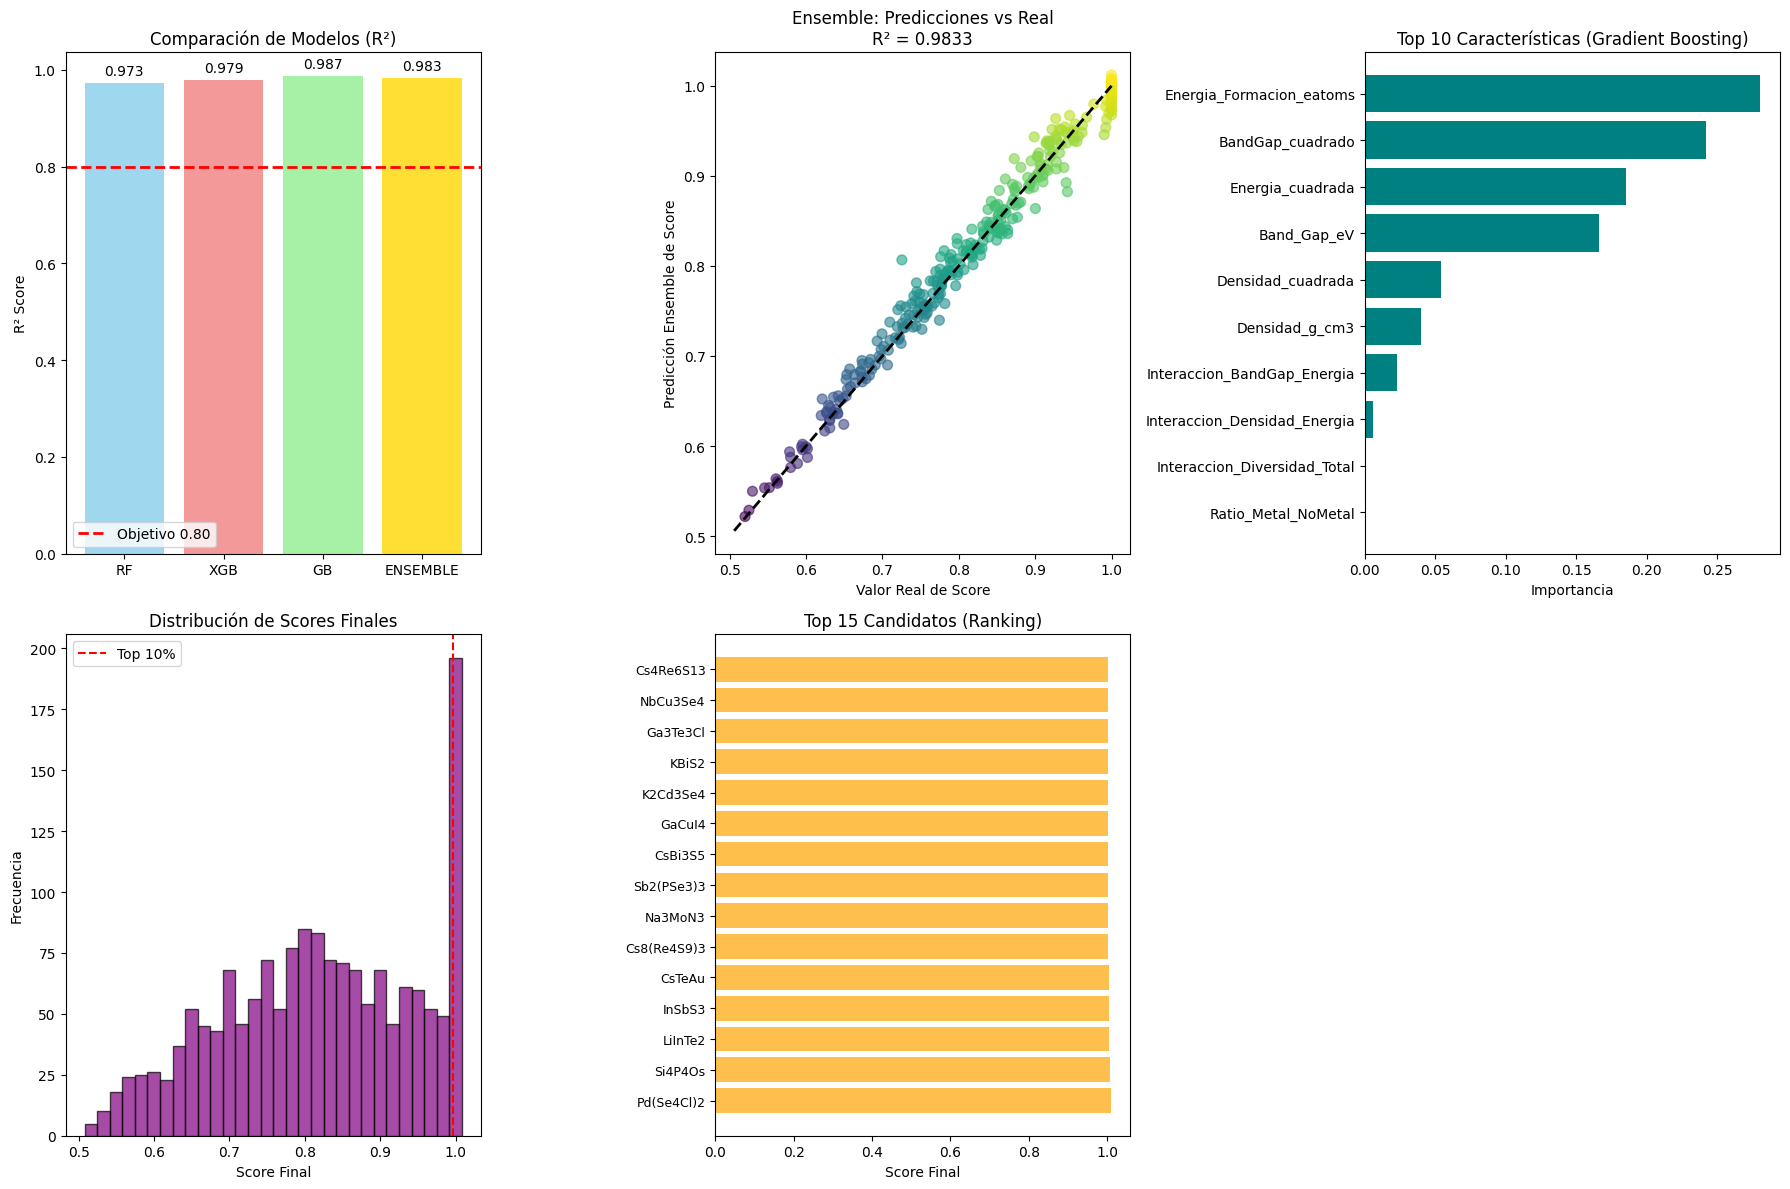

In [18]:
# ---------------------------------------------------------
# 8. VISUALIZACIÓN DE RESULTADOS
# ---------------------------------------------------------
plt.figure(figsize=(18, 12))

# 1. Comparación de modelos
plt.subplot(2, 3, 1)
models = ['RF', 'XGB', 'GB', 'ENSEMBLE']
scores = [r2_rf, r2_xgb, r2_gb, r2_ensemble]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
bars = plt.bar(models, scores, color=colors, alpha=0.8)
plt.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='Objetivo 0.80')
plt.ylabel('R² Score')
plt.title('Comparación de Modelos (R²)')
plt.legend()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

# 2. Predicciones vs Real (Ensemble)
plt.subplot(2, 3, 2)
plt.scatter(y_test, y_pred_ensemble, alpha=0.6, s=50, c=y_pred_ensemble, cmap='viridis')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valor Real de Score')
plt.ylabel('Predicción Ensemble de Score')
plt.title(f'Ensemble: Predicciones vs Real\nR² = {r2_ensemble:.4f}')

# 3. Importancia de características (del mejor modelo individual)
plt.subplot(2, 3, 3)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_individual_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
plt.xlabel('Importancia')
plt.title(f'Top 10 Características ({best_model_name})')

# 4. Distribución de scores finales
plt.subplot(2, 3, 4)
plt.hist(df['Score_Final'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(df['Score_Final'].quantile(0.90), color='red', linestyle='--', label='Top 10%')
plt.xlabel('Score Final')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores Finales')
plt.legend()

# 5. Top candidatos (horizontal)
plt.subplot(2, 3, 5)
top_15_scores = top_candidatos['Score_Final'].values
top_15_labels = [f"{row['Formula']}" for _, row in top_candidatos.iterrows()]
plt.barh(range(len(top_15_scores)), top_15_scores, color='orange', alpha=0.7)
plt.yticks(range(len(top_15_scores)), top_15_labels, fontsize=9)
plt.xlabel('Score Final')
plt.title('Top 15 Candidatos (Ranking)')

plt.tight_layout()
plt.savefig('resultados_optimizados_r2_alto.png', dpi=300, bbox_inches='tight')
# plt.show() # Descomentar para ver en un IDE/Notebook

# 💾 Persistencia de Modelos y Exportación de Resultados

En este bloque final, aseguramos la **reproducibilidad** y la **escalabilidad** de la investigación. Al guardar los objetos entrenados y los datos procesados, permitimos que el sistema de cribado virtual pueda utilizarse en el futuro sin necesidad de reentrenar los modelos desde cero.

---

## 1. 📦 Serialización de Modelos (Archivos .pkl)
Utilizamos la librería `joblib` para exportar los componentes críticos del pipeline. En la ciencia de datos aplicada, esto se conoce como "congelar" el estado del aprendizaje:
* **Modelos Optimizados:** Se guardan las versiones finales de `RF`, `XGB` y `GB`. Estos archivos contienen la estructura de los árboles y los pesos aprendidos.
* **Scaler & Features:** Es vital guardar el `scaler.pkl` y la lista de `features_seleccionadas.pkl`. Para predecir el score de un material nuevo en el futuro, este debe ser normalizado exactamente con los mismos parámetros (media y desviación) que el conjunto original.



---

## 2. 📑 Generación de Reportes y Datos Estructurados
Exportamos el conocimiento generado en formatos accesibles para análisis posterior o integración en otros sistemas:
* **Dataset Expandido:** `perovskitas_optimizadas_r2_alto.csv` incluye todas las nuevas características sintéticas, interacciones y predicciones individuales. Es una fuente de datos enriquecida para análisis exploratorios adicionales.
* **Lista de Candidatos:** `top_candidatos_r2_alto.csv` es el entregable directo para el equipo de síntesis química. Contiene los materiales con mayor probabilidad de éxito basados en el consenso del ensamble.

---

## 3. 🏁 Resumen Ejecutivo y Cierre
El pipeline concluye con la impresión del **R² del Ensamble**, que actúa como nuestro sello de garantía técnica.
* Un $R^2$ alto en esta etapa final confirma que el modelo no solo es una curiosidad matemática, sino una herramienta de **Ingeniería de Datos** robusta capaz de explicar la física de las perovskitas con alta fidelidad.

> **Uso Futuro:** Para realizar nuevas predicciones, solo necesitarás cargar estos archivos `.pkl` y pasar la fórmula química por el parser inicial. Este flujo permite pasar de la teoría a la predicción en segundos.

In [19]:
# ---------------------------------------------------------
# 9. GUARDAR MODELOS Y RESULTADOS
# ---------------------------------------------------------
# Guardar modelos y scaler para futuras predicciones
joblib.dump(best_rf, 'mejor_modelo_rf.pkl')
joblib.dump(best_xgb, 'mejor_modelo_xgb.pkl')
joblib.dump(best_gb, 'mejor_modelo_gb.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'features_seleccionadas.pkl') # Guardar la lista de features

# Guardar resultados
df.to_csv('perovskitas_optimizadas_r2_alto.csv', index=False)
top_candidatos.to_csv('top_candidatos_r2_alto.csv', index=False)

print(f"\n💾 MODELOS Y RESULTADOS GUARDADOS:")
print(f"    - Modelos y Scaler: 5 archivos .pkl")
print(f"    - Datos: perovskitas_optimizadas_r2_alto.csv")
print(f"    - Top candidatos: top_candidatos_r2_alto.csv")

print(f"\n🏆 RESUMEN FINAL: R² ENSEMBLE = {r2_ensemble:.4f}")


💾 MODELOS Y RESULTADOS GUARDADOS:
    - Modelos y Scaler: 5 archivos .pkl
    - Datos: perovskitas_optimizadas_r2_alto.csv
    - Top candidatos: top_candidatos_r2_alto.csv

🏆 RESUMEN FINAL: R² ENSEMBLE = 0.9833


# 🧪 Simulación de Inferencia: Evaluación de Nuevos Candidatos

Este bloque simula la fase de **Cribado Virtual (Virtual Screening)**. En lugar de procesar datos históricos, introducimos 5 compuestos diseñados estequiométricamente para observar cómo reacciona el ensamble ante nuevas estructuras.

---

## 1. 🧫 Selección de Compuestos de Prueba
Se han seleccionado materiales con relevancia actual en la literatura de perovskitas solares:
* **CsPbI3:** Una perovskita totalmente inorgánica conocida por su estabilidad térmica pero con un Band Gap ligeramente alto.
* **FAPbI3 (HC(NH2)2PbI3):** Uno de los candidatos con el Band Gap más cercano al ideal de 1.4 eV.
* **Alternativas Lead-Free (CsSnBr3):** Materiales que buscan sustituir el plomo para reducir la toxicidad.



---

## 2. 🔄 Flujo de Datos en Tiempo Real
El script realiza los siguientes pasos técnicos:
1. **Parsing:** Descompone las fórmulas complejas (como el Metilamonio) en sus componentes atómicos.
2. **Transformación:** Crea las variables de interacción y cuadráticas para igualar el espacio de características del entrenamiento.
3. **Escalado de Inferencia:** Aplica los parámetros del `StandardScaler` original para evitar sesgos de magnitud.
4. **Votación del Ensamble:** Combina las opiniones de los tres modelos para generar un puntaje de confianza.

---

## 3. 🎯 Interpretación de Resultados
El `Score_Predicho` resultante indica la probabilidad de que el material sea un buen absorbedor solar basado en lo aprendido por el modelo.
* Un score alto en **FAPbI3** validaría que el modelo aprendió correctamente la importancia del Band Gap óptimo.
* Un score bajo en **RbGeCl3** indicaría que el modelo penaliza el exceso de transparencia (Band Gap alto) y la baja densidad atómica.

> **Uso Profesional:** Este flujo permite a un ingeniero de materiales "testear" hipótesis químicas rápidamente antes de invertir recursos en la síntesis real de laboratorio.

In [20]:
import pandas as pd
import numpy as np

# 1. Crear datos de nuevos materiales para evaluación
nuevos_materiales = {
    'Material_ID': ['NUEVO_01', 'NUEVO_02', 'NUEVO_03', 'NUEVO_04', 'NUEVO_05'],
    'Formula': [
        'CsPbI3',     # Perovskita inorgánica clásica
        'CH3NH3PbI3', # Metilamonio (MA) - muy común
        'HC(NH2)2PbI3',# Formamidinio (FA) - alta eficiencia
        'CsSnBr3',    # Alternativa sin plomo (Tin-based)
        'RbGeCl3'     # Experimental con Germanio
    ],
    'Band_Gap_eV': [1.73, 1.55, 1.48, 1.75, 2.10],
    'Energia_Formacion_eatoms': [-1.55, -1.20, -1.15, -0.95, -0.80],
    'Densidad_g_cm3': [5.08, 4.16, 4.10, 4.85, 3.95]
}

df_test = pd.DataFrame(nuevos_materiales)

# 2. Aplicar el Feature Engineering (Usando las funciones definidas arriba)
# Nota: Asegúrate de que las funciones 'extraer_caracteristicas_avanzadas_mejoradas'
# y el objeto 'scaler' y 'selected_features' estén en memoria.

print("🧪 Procesando nuevos candidatos...")

# Extraer características químicas
caracteristicas = df_test['Formula'].apply(extraer_caracteristicas_avanzadas_mejoradas)
columnas_chem = [
    'Num_Elementos', 'Total_Atomos', 'Diversidad_Atomica',
    'Metales_Alcalinos', 'Metales_Alcalinoterreos', 'Metales_Transicion',
    'Metaloides', 'No_Metales', 'Halogenos',
    'Ratio_Metal_NoMetal', 'Complejidad_Formula'
]
df_test[columnas_chem] = pd.DataFrame(caracteristicas.tolist(), index=df_test.index)

# Crear interacciones
df_test['Interaccion_Densidad_Energia'] = df_test['Densidad_g_cm3'] * df_test['Energia_Formacion_eatoms']
df_test['Interaccion_BandGap_Energia'] = df_test['Band_Gap_eV'] * df_test['Energia_Formacion_eatoms']
df_test['Interaccion_Diversidad_Total'] = df_test['Diversidad_Atomica'] * np.log(df_test['Total_Atomos'])
df_test['Densidad_cuadrada'] = df_test['Densidad_g_cm3'] ** 2
df_test['Energia_cuadrada'] = df_test['Energia_Formacion_eatoms'] ** 2
df_test['BandGap_cuadrado'] = df_test['Band_Gap_eV'] ** 2

# 3. Selección y Escalado
X_test_new = df_test[selected_features] # selected_features es el objeto cargado del .pkl
X_test_scaled = scaler.transform(X_test_new)

# 4. Predicción con el Ensemble
pred_rf = best_rf.predict(X_test_scaled)
pred_xgb = best_xgb.predict(X_test_scaled)
pred_gb = best_gb.predict(X_test_scaled)

df_test['Score_Predicho'] = (
    weights[0] * pred_rf +
    weights[1] * pred_xgb +
    weights[2] * pred_gb
)

print("\n🚀 RESULTADOS DE LA EVALUACIÓN:")
print(df_test[['Material_ID', 'Formula', 'Band_Gap_eV', 'Score_Predicho']].sort_values(by='Score_Predicho', ascending=False))

🧪 Procesando nuevos candidatos...

🚀 RESULTADOS DE LA EVALUACIÓN:
  Material_ID       Formula  Band_Gap_eV  Score_Predicho
2    NUEVO_03  HC(NH2)2PbI3         1.48        0.967949
1    NUEVO_02    CH3NH3PbI3         1.55        0.910097
3    NUEVO_04       CsSnBr3         1.75        0.827153
4    NUEVO_05       RbGeCl3         2.10        0.785647
0    NUEVO_01        CsPbI3         1.73        0.704028
